In [1]:
#in this notebook we will implement MOCO paper:
#https://arxiv.org/pdf/1911.05722.pdf
#CNN architecture we change, but MOCO loss function is the same, and training is the same
#we use 5 different data gmentations (rotations, blur, color distortion, cropping and resizing) for defining the positive samples

#training is done on 1 GPU, training setting are:
#1. Use the entire training data to learn the representations.
#2. Once the representations are learned, use a linear and logistic layers and retrain with 10-50% of supervised training data.
#3. Experiment with two different sizes for the encoder dictionary.

In [2]:
version = 0
experiment = 'moco'
experiment_name = experiment + '_' + str(version)

In [3]:
#imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchsummary import summary

from functools import partial
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm import tqdm
import numpy as np

In [53]:
from PIL import Image
#tensorboard
from torch.utils.tensorboard import SummaryWriter
#mathplotlib
import matplotlib.pyplot as plt
#tsne
from sklearn.manifold import TSNE


In [5]:
import importlib

import models
importlib.reload(models)
from models import  pentaClassifier, binaryClassifier, baseClassifier, convNet


import config
from config import cfg
importlib.reload(config)



<module 'config' from '/home/lisa/bhartendu/adrl/A3/config.py'>

In [6]:
#device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### CIFAR10

In [7]:
from torchvision.datasets import CIFAR10

In [8]:
import argparse
import json
import math
import os
import pandas as pd

In [9]:
#seed
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
# Torch RNG
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)



## HYPER - PARAMETERS

In [10]:
results_dir = 'results/'
moco_pretrained_dir = results_dir+'model_'+experiment_name

#### MOCO - HYPER - PARAMETERS

In [11]:
moco_dim = 512
moco_k = 4096
moco_m = 0.99
moco_t = 0.07
moco_loss_symmetric = True

#### MOCO - TRAINING

In [12]:
lr = 0.06
epochs = 200  # 200
batch_size = 512
schedule = [120, 160]
wd = 5e-4
cos = True      # cosine lr schedule
bn_splits = 8

#### Supervised - Hyper - Parameters

In [13]:
fraction_training_data = 0.50

#### Supervised Training

In [45]:
super_lr = 1.0
super_epochs = 200


## data-loader

#### Adapted from pytorch code of Contrastive learning libs: http://github.com/zhirongw/lemniscate.pytorch

In [15]:
class CIFAR10Pair(CIFAR10):
    """CIFAR10 Dataset.
    """
    def __getitem__(self, index):
        img = self.data[index]
        img = Image.fromarray(img)

        if self.transform is not None:
            im_1 = self.transform(img)
            im_2 = self.transform(img)

        return im_1, im_2

# train_transform = transforms.Compose([
#     transforms.RandomResizedCrop(32),
#     transforms.RandomHorizontalFlip(p=0.5),
#     transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
#     transforms.RandomGrayscale(p=0.2),
#     transforms.ToTensor(),
#     transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])])
#we will aplly 5 different data gmentations (rotations, blur, color distortion, cropping and resizing) for defining the positive samples
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(32),
    #random rotation with random angle
    transforms.RandomRotation([-1* torch.rand(1)*360 , torch.rand(1)*360]),
    #random blur
    transforms.RandomApply([transforms.GaussianBlur(3, sigma=[0.1, 2.0])], p=0.5),
    #random color distortion
    transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])])
    

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])])

# data prepare
train_data = CIFAR10Pair(root='data', train=True, transform=train_transform, download=True)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=16, pin_memory=True, drop_last=True)

memory_data = CIFAR10(root='data', train=True, transform=test_transform, download=True)
memory_loader = DataLoader(memory_data, batch_size=batch_size, shuffle=False, num_workers=16, pin_memory=True)

test_data = CIFAR10(root='data', train=False, transform=test_transform, download=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=16, pin_memory=True)


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


## Split Batch implementation adapted from: 
#### https://github.com/davidcpage/cifar10-fast/blob/master/torch_backend.py

In [16]:
class SplitBatchNorm(nn.BatchNorm2d):
    def __init__(self, num_features, num_splits= bn_splits, **kw):
        super().__init__(num_features, **kw)
        self.num_splits = num_splits
        
    def forward(self, input):
        N, C, H, W = input.shape
        if self.training or not self.track_running_stats:
            running_mean_split = self.running_mean.repeat(self.num_splits)
            running_var_split = self.running_var.repeat(self.num_splits)
            outcome = nn.functional.batch_norm(
                input.view(-1, C * self.num_splits, H, W), running_mean_split, running_var_split, 
                self.weight.repeat(self.num_splits), self.bias.repeat(self.num_splits),
                True, self.momentum, self.eps).view(N, C, H, W)
            self.running_mean.data.copy_(running_mean_split.view(self.num_splits, C).mean(dim=0))
            self.running_var.data.copy_(running_var_split.view(self.num_splits, C).mean(dim=0))
            return outcome
        else:
            return nn.functional.batch_norm(
                input, self.running_mean, self.running_var, 
                self.weight, self.bias, False, self.momentum, self.eps)

#### the following class was adapted from facebookresearch/moco which replaces 

In [17]:
# #write a function to replace all the batchnorm layers with splitbatchnorm layers if bn_splits > 1
# def replace_bn(model, num_splits):
#     #if num_splits is 1, then return the model
#     if num_splits == 1:
#         return model
#     norm_layer = partial(SplitBatchNorm, num_splits=bn_splits) if bn_splits > 1 else nn.BatchNorm2d
#     for name, child in model.named_children():
#         if isinstance(child, nn.BatchNorm2d):
#             setattr(model, name, norm_layer(child.num_features))
#         else:
#             replace_bn(child, num_splits)
#     return model
    

            

In [18]:
#function to use the class SplitBatchNorm to replace the batchnorm layers with splitbatchnorm layers if bn_splits > 1
#the init has num_features and num_splits as arguments, thus while changing the batchnorm layers to splitbatchnorm layers, we need to pass the num_splits as an argument
def replace_bn(model, num_splits):
    #if num_splits is 1, then return the model
    if num_splits == 1:
        return model
    #loop through the model and replace the batchnorm layers with splitbatchnorm layers using the class SplitBatchNorm
    norm_layer = partial(SplitBatchNorm, num_splits=bn_splits)
    for name, child in model.named_children():
        if isinstance(child, nn.BatchNorm2d):
            #change the batchnorm layers to splitbatchnorm layers by the return of the function : SplitBatchNorm(child.num_features, num_splits)
            #replace batchnorm with norm_layer
            setattr(model, name, norm_layer(child.num_features))
        else:
            replace_bn(child, num_splits)

## Model

In [19]:
#create a model class named ModelBAse that will have the exact same architecture as the convNet class but will flatten the output of the model, to get embedding of the model
class ModelBase(nn.Module):
    def __init__(self, cfg=cfg['model'], device=device):
        super().__init__()
        self.cfg = cfg
        self.device = device
        self.conv = convNet(cfg, device=device)
        self.flat = nn.Flatten()
        self.fc = nn.Linear(moco_dim, moco_dim)
        
        

        
    def forward(self, x):
        x = self.flat(self.conv(x))
        #pass the output of the model through a linear layer
        x = self.fc(x)

        return x


In [20]:
#buils an object of the ModelBase class
model = ModelBase()


-----------------------------------------------------------
ConvNet
ModuleList(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Dropout(p=0.3, inplace=False)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): ReLU()
  (8): Dropout(p=0.3, inplace=False)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU()
  (13): Dropout(p=0.3, inplace=False)
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)
---------------------------------------------

In [21]:
#summary of the model
summary(model, input_size=(3, 32, 32), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             864
       BatchNorm2d-2           [-1, 32, 30, 30]              64
              ReLU-3           [-1, 32, 30, 30]               0
           Dropout-4           [-1, 32, 30, 30]               0
         MaxPool2d-5           [-1, 32, 15, 15]               0
            Conv2d-6           [-1, 64, 13, 13]          18,432
       BatchNorm2d-7           [-1, 64, 13, 13]             128
              ReLU-8           [-1, 64, 13, 13]               0
           Dropout-9           [-1, 64, 13, 13]               0
        MaxPool2d-10             [-1, 64, 6, 6]               0
           Conv2d-11            [-1, 128, 4, 4]          73,728
      BatchNorm2d-12            [-1, 128, 4, 4]             256
             ReLU-13            [-1, 128, 4, 4]               0
          Dropout-14            [-1, 12

---------------------------------------------------------------------------
---------------------------------------------------------------------------

## MOCO

#### defininng MOCO Training Routine: Including the queue and the memory bank and key encoder, query encoder




In [22]:
class ModelMoCo(nn.Module):
    def __init__(self, dim=moco_dim, K=moco_k, m=moco_m, T=moco_t, bn_splits=bn_splits, symmetric=True):
        super(ModelMoCo, self).__init__()

        self.K = K
        self.m = m
        self.T = T
        self.symmetric = symmetric

        # create the encoders
        self.encoder_q = ModelBase()
        self.encoder_k = ModelBase()

        for param_q, param_k in zip(self.encoder_q.parameters(), self.encoder_k.parameters()):
            param_k.data.copy_(param_q.data)  # initialize
            param_k.requires_grad = False  # not update by gradient

        # create the queue
        self.register_buffer("queue", torch.randn(dim, K))
        self.queue = nn.functional.normalize(self.queue, dim=0)

        self.register_buffer("queue_ptr", torch.zeros(1, dtype=torch.long))

    @torch.no_grad()
    def _momentum_update_key_encoder(self):
        """
        Momentum update of the key encoder
        """
        for param_q, param_k in zip(self.encoder_q.parameters(), self.encoder_k.parameters()):
            param_k.data = param_k.data * self.m + param_q.data * (1. - self.m)

    @torch.no_grad()
    def _dequeue_and_enqueue(self, keys):
        batch_size = keys.shape[0]

        ptr = int(self.queue_ptr)
        assert self.K % batch_size == 0  # for simplicity

        # replace the keys at ptr (dequeue and enqueue)
        self.queue[:, ptr:ptr + batch_size] = keys.t()  # transpose
        ptr = (ptr + batch_size) % self.K  # move pointer

        self.queue_ptr[0] = ptr

    @torch.no_grad()
    def _batch_shuffle_single_gpu(self, x):
        """
        Batch shuffle, for making use of BatchNorm.
        """
        # random shuffle index
        idx_shuffle = torch.randperm(x.shape[0]).cuda()

        # index for restoring
        idx_unshuffle = torch.argsort(idx_shuffle)

        return x[idx_shuffle], idx_unshuffle

    @torch.no_grad()
    def _batch_unshuffle_single_gpu(self, x, idx_unshuffle):
        """
        Undo batch shuffle.
        """
        return x[idx_unshuffle]

    def contrastive_loss(self, im_q, im_k):
        # compute query features
        q = self.encoder_q(im_q)  # queries: NxC
        q = nn.functional.normalize(q, dim=1)  # already normalized

        # compute key features
        with torch.no_grad():  # no gradient to keys
            # shuffle for making use of BN
            im_k_, idx_unshuffle = self._batch_shuffle_single_gpu(im_k)

            k = self.encoder_k(im_k_)  # keys: NxC
            k = nn.functional.normalize(k, dim=1)  # already normalized

            # undo shuffle
            k = self._batch_unshuffle_single_gpu(k, idx_unshuffle)

        # compute logits
        # Einstein sum is more intuitive
        # positive logits: Nx1
        l_pos = torch.einsum('nc,nc->n', [q, k]).unsqueeze(-1)
        # negative logits: NxK
        l_neg = torch.einsum('nc,ck->nk', [q, self.queue.clone().detach()])

        # logits: Nx(1+K)
        logits = torch.cat([l_pos, l_neg], dim=1)

        # apply temperature
        logits /= self.T

        # labels: positive key indicators
        labels = torch.zeros(logits.shape[0], dtype=torch.long).cuda()
        
        loss = nn.CrossEntropyLoss().cuda()(logits, labels)

        return loss, q, k

    def forward(self, im1, im2):
        """
        Input:
            im_q: a batch of query images
            im_k: a batch of key images
        Output:
            loss
        """

        # update the key encoder
        with torch.no_grad():  # no gradient to keys
            self._momentum_update_key_encoder()

        # compute loss
        if self.symmetric:  # asymmetric loss
            loss_12, q1, k2 = self.contrastive_loss(im1, im2)
            loss_21, q2, k1 = self.contrastive_loss(im2, im1)
            loss = loss_12 + loss_21
            k = torch.cat([k1, k2], dim=0)
        else:  # asymmetric loss
            loss, q, k = self.contrastive_loss(im1, im2)

        self._dequeue_and_enqueue(k)

        return loss



#### Optimizer: SGD

In [23]:
# define optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)

##### learning rate schedule

In [24]:
# lr scheduler for training
def adjust_learning_rate(optimizer, epoch):
    """Decay the learning rate based on schedule"""
    learning_rate = lr 
    if cos:  # cosine lr schedule
        learning_rate *= 0.5 * (1. + math.cos(math.pi * epoch / epochs))
    else:  # stepwise lr schedule
        for milestone in schedule:
            learning_rate *= 0.1 if epoch >= milestone else 1.
    for param_group in optimizer.param_groups:
        param_group['lr'] = learning_rate

#### Training Loop

In [137]:
# train for one epoch
#create batch writer
batch_writer = SummaryWriter(f'{results_dir}/run/')
batch_count = 0


def train(net, data_loader, train_optimizer, epoch):
    net.train()
    adjust_learning_rate(optimizer, epoch)

    total_loss, total_num, train_bar = 0.0, 0, tqdm(data_loader)
    for im_1, im_2 in train_bar:
        im_1, im_2 = im_1.cuda(non_blocking=True), im_2.cuda(non_blocking=True)

        loss = net(im_1, im_2)
        
        train_optimizer.zero_grad()
        loss.backward()
        train_optimizer.step()

        #write to batch writer
        #make batch count static
        global batch_count
        batch_writer.add_scalar('Loss/train_batch', loss, batch_count)
        batch_count += 1
        ########

        total_num += data_loader.batch_size
        total_loss += loss.item() * data_loader.batch_size
        train_bar.set_description('Train Epoch: [{}/{}], lr: {:.6f}, Loss: {:.4f}'.format(epoch, epochs, optimizer.param_groups[0]['lr'], total_loss / total_num))

    return total_loss / total_num



2022-12-03 12:31:34.159879: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


## Train

##### instantiate the model

In [25]:
# create model
model = ModelMoCo(
        dim=moco_dim,
        K=moco_k,
        m=moco_m,
        T=moco_t,

        bn_splits=bn_splits,
        symmetric=moco_loss_symmetric,
    ).to(device)
print(model.encoder_q)

-----------------------------------------------------------
ConvNet
ModuleList(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Dropout(p=0.3, inplace=False)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): ReLU()
  (8): Dropout(p=0.3, inplace=False)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU()
  (13): Dropout(p=0.3, inplace=False)
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)
---------------------------------------------

In [26]:
# logging
results = {'train_loss': []}
#if results_dir not exists, then create one
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
#initialize summary writer in run directory in results_dir
writer = SummaryWriter(f'{results_dir}/run/')

2022-12-03 23:31:10.660036: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


##### training loop

In [28]:
# training loop
epoch_start = 1
for epoch in range(epoch_start, epochs + 1):
    
    train_loss = train(model, train_loader, optimizer, epoch)
    results['train_loss'].append(train_loss)
    writer.add_scalar('Loss/train_epoch', train_loss, epoch)
    #if last epoch save model
    if epoch == epochs:
        torch.save(model.state_dict(), moco_pretrained_dir+'.pth')

Train Epoch: [1/200], lr: 0.059996, Loss: 15.9256: 100%|██████████| 97/97 [00:09<00:00,  9.92it/s]
Train Epoch: [2/200], lr: 0.059985, Loss: 16.1166: 100%|██████████| 97/97 [00:08<00:00, 12.09it/s]
Train Epoch: [3/200], lr: 0.059967, Loss: 16.1335: 100%|██████████| 97/97 [00:08<00:00, 11.94it/s]
Train Epoch: [4/200], lr: 0.059941, Loss: 16.1301: 100%|██████████| 97/97 [00:08<00:00, 11.74it/s]
Train Epoch: [5/200], lr: 0.059908, Loss: 16.1248: 100%|██████████| 97/97 [00:08<00:00, 11.71it/s]
Train Epoch: [6/200], lr: 0.059867, Loss: 16.1305: 100%|██████████| 97/97 [00:08<00:00, 11.27it/s]
Train Epoch: [7/200], lr: 0.059819, Loss: 16.1231: 100%|██████████| 97/97 [00:08<00:00, 11.03it/s]
Train Epoch: [8/200], lr: 0.059763, Loss: 16.1269: 100%|██████████| 97/97 [00:08<00:00, 11.77it/s]
Train Epoch: [9/200], lr: 0.059701, Loss: 16.1218: 100%|██████████| 97/97 [00:08<00:00, 11.62it/s]
Train Epoch: [10/200], lr: 0.059631, Loss: 16.0959: 100%|██████████| 97/97 [00:08<00:00, 11.83it/s]
Train Epo

In [59]:
#load saved moco model but return only the encoder_q
def load_moco_model(path = 'results/model_moco_1'):
    model = ModelMoCo(
        dim=moco_dim,
        K=moco_k,
        m=moco_m,
        T=moco_t,

        bn_splits=bn_splits,
        symmetric=moco_loss_symmetric,
    )
    model.load_state_dict(torch.load(path+'.pth'))
    return model.encoder_q


# Supervised Training

# Using the Learned Representations

In [28]:
#we will test using the standard Linear classification Protocol
#the Linear classification Protocol is : as unsupervised representations are learned, use a linear and logistic layers and retrain with 10-50% of supervised training data

#we have 2 test tasks 
#TASK 1: Binary Classifier
#TASk 2: 5-class classification

In [29]:
#we define a classifier class, that takes in number of classes
#it will first make a copy of the ModelMoCo class, load the pretrained weights, make the weights non-trainable
#then we will add a linear layer and a logistic layer to the model to match the number of classes
class Classifier(nn.Module):
    def __init__(self, num_classes):
        super(Classifier, self).__init__()
        self.moco = load_moco_model()
        #freeze the weights
        for param in self.moco.parameters():
            param.requires_grad = False
        #add a linear layer and a softmax layer
        self.linear = nn.Linear(moco_dim, num_classes)
        #add logistic layer
        self.softmax = nn.Softmax(dim=1)
    def forward(self, x):
        x = self.moco(x)
        x = self.linear(x)
        x = self.softmax(x)
        return x


In [30]:
#print summary of the model
model = Classifier(2)
summary(model.to(device), (3, 32, 32))

-----------------------------------------------------------
ConvNet
ModuleList(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Dropout(p=0.3, inplace=False)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): ReLU()
  (8): Dropout(p=0.3, inplace=False)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU()
  (13): Dropout(p=0.3, inplace=False)
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)
---------------------------------------------

In [31]:
print(model)

Classifier(
  (moco): ModelBase(
    (conv): convNet(
      (net): ModuleList(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Dropout(p=0.3, inplace=False)
        (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (7): ReLU()
        (8): Dropout(p=0.3, inplace=False)
        (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (12): ReLU()
        (13): Dropout(p=0.3, inplace=False)
        (14): MaxPool2d(kernel_size=2, stride=2

#### dataloader for supervised training

In [32]:
#define train and test loaders
#get train loader only fraction_trainig_data
#we load cifar10 dataset from torchvision
train_data_supervised = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=test_transform)
#take only fraction of training data : fraction_training_data 
train_data_supervised = torch.utils.data.Subset(train_data_supervised, indices = np.random.choice(len(train_data_supervised), int(fraction_training_data*len(train_data_supervised)), replace=False))

#train dataloader
train_loader_supervised = torch.utils.data.DataLoader(train_data_supervised, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)



Files already downloaded and verified


#### Supervised Training Routine

In [41]:
#we will have a supervised training loop on a model given by the classifier class
def supervised_training(model,label_fun, model_save_path, epochs= super_epochs, lr= 1.0):

    #loss function
    criterion = torch.nn.CrossEntropyLoss()
    #optimizer, we will only train the linear and logistic layers, thus we will only pass the parameters of the linear and logistic layers, i.e only the trainable parameters
    #pass only the parameters of last linear layer and softmax layer
    optimizer = torch.optim.SGD(model.linear.parameters(), lr=super_lr)
    #CosineAnnealingLR scheduler
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)



    model.train()
    #send model to device
    model.to(device)
    train_bar = tqdm(train_loader)
    #loop for number of epochs
    batch_counter = 0
    for epoch in range(epochs):
        epoch_loss = 0
        total_correct = 0
        total_items = 0
        #loop for number of batches
        for batch_idx, (data, target) in enumerate(train_loader_supervised):
            #send data and target to device
            data, target = data.to(device), target
            #get binary target
            target = label_fun(target)
            #send to device
            target = target.to(device)
            #zero the gradients
            optimizer.zero_grad()
            #forward pass
            output = model(data)
            #calculate loss
            loss = criterion(output, target)
            #backward pass
            loss.backward()
            #update weights
            optimizer.step()
            #update epoch loss
            epoch_loss += loss.item()
            #get classification accuracy
            _, predicted = torch.max(output.data, 1)
            total = target.size(0)
            correct = (predicted == target).sum().item()
            total_correct += correct
            total_items += total
            #update progress bar
            # train_bar.set_description(desc= f'epoch {epoch} loss={loss.item()} batch_id={batch_idx} Accuracy={100 * correct / total}')
            #print
            if batch_idx % 25 == 0:
                print('Epoch : %d/%d, Batch : %d/%d, Loss : %.4f, Accuracy : %.4f'
                    %(epoch+1, epochs, batch_idx+1, len(train_loader_supervised), loss.item(), 100 * correct / total))

            #write to tensorboard
            writer.add_scalar('Loss/batch_train_supervised_binary_classifier', loss.item(), batch_counter)
            writer.add_scalar('Accuracy/batch_train_supervised_binary_classifier', 100 * correct / total, batch_counter)
            batch_counter += 1

        #update scheduler
        scheduler.step()
        #print epoch loss
        print("epoch loss",epoch_loss/len(train_loader))
        #print epoch accuracy
        print("epoch accuracy",100 * total_correct/total_items)
        #write to tensorboard
        writer.add_scalar('Loss/epoch_train_supervised_binary_classifier', epoch_loss/len(train_loader), epoch)
        writer.add_scalar('Accuracy/epoch_train_supervised_binary_classifier', 100 * total_correct/total_items, epoch)
        #if last epoch , then save the model
        if epoch == epochs-1:
            torch.save(model.state_dict(), model_save_path+'.pt')
    return model



    


## TASK 0: CIFAR10 10-class classification

In [46]:
#define 10 class label
def ten_class_label(ip):
    return ip

In [47]:
#we will call the supervised training function for 10 class classification
#we will build the parameters for the function
#model
model = Classifier(10)
cifar_classifier_model_save_path = moco_pretrained_dir + '_supervised_ten_class_classifier'
#call the function
model = supervised_training(model, ten_class_label, cifar_classifier_model_save_path, epochs= super_epochs)

-----------------------------------------------------------
ConvNet
ModuleList(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Dropout(p=0.3, inplace=False)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): ReLU()
  (8): Dropout(p=0.3, inplace=False)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU()
  (13): Dropout(p=0.3, inplace=False)
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)
---------------------------------------------

  0%|          | 0/97 [00:00<?, ?it/s]

Epoch : 1/200, Batch : 1/49, Loss : 2.3049, Accuracy : 9.1797
Epoch : 1/200, Batch : 26/49, Loss : 2.1825, Accuracy : 27.5391
epoch loss 1.106910248392636
epoch accuracy 27.096
Epoch : 2/200, Batch : 1/49, Loss : 2.1283, Accuracy : 34.7656
Epoch : 2/200, Batch : 26/49, Loss : 2.0955, Accuracy : 38.8672
epoch loss 1.0727117233669634
epoch accuracy 34.296
Epoch : 3/200, Batch : 1/49, Loss : 2.0952, Accuracy : 36.3281
Epoch : 3/200, Batch : 26/49, Loss : 2.0983, Accuracy : 36.9141
epoch loss 1.0586382113781172
epoch accuracy 37.388
Epoch : 4/200, Batch : 1/49, Loss : 2.0878, Accuracy : 37.8906
Epoch : 4/200, Batch : 26/49, Loss : 2.0596, Accuracy : 41.7969
epoch loss 1.0501558411981642
epoch accuracy 38.752
Epoch : 5/200, Batch : 1/49, Loss : 2.0444, Accuracy : 42.7734
Epoch : 5/200, Batch : 26/49, Loss : 2.0813, Accuracy : 37.1094
epoch loss 1.045280318899253
epoch accuracy 40.148
Epoch : 6/200, Batch : 1/49, Loss : 2.0864, Accuracy : 38.4766
Epoch : 6/200, Batch : 26/49, Loss : 2.0479, 

  0%|          | 0/97 [04:22<?, ?it/s]

epoch loss 1.0059232453710025
epoch accuracy 47.012


In [ ]:
#wew will visualize the features with tsne
#we will use the 


## TASK 1: Binary Classifier

In [48]:
#we will define binary label function that will map the input label: 0 to 9 to either 0 or 1
#y = torch.tensor([1 if x in [2,3,4,5,6,7] else 0 for x in y])
def binary_label(y):
    y = torch.tensor([1 if x in [2,3,4,5,6,7] else 0 for x in y])
    return y

In [49]:
#we will call the supervised training function for binary classification
#we will build the parameters for the function
#model
model = Classifier(2)
binary_model_save_path = moco_pretrained_dir + '_supervised_binary_classifier'
#call the function
model = supervised_training(model, binary_label, binary_model_save_path, epochs= super_epochs)

-----------------------------------------------------------
ConvNet
ModuleList(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Dropout(p=0.3, inplace=False)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): ReLU()
  (8): Dropout(p=0.3, inplace=False)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU()
  (13): Dropout(p=0.3, inplace=False)
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)
---------------------------------------------

  0%|          | 0/97 [00:00<?, ?it/s]

Epoch : 1/200, Batch : 1/49, Loss : 0.6996, Accuracy : 56.4453
Epoch : 1/200, Batch : 26/49, Loss : 0.5315, Accuracy : 77.3438
epoch loss 0.27524131106347155
epoch accuracy 75.72
Epoch : 2/200, Batch : 1/49, Loss : 0.4537, Accuracy : 85.9375
Epoch : 2/200, Batch : 26/49, Loss : 0.4741, Accuracy : 83.2031
epoch loss 0.24065668650509156
epoch accuracy 82.888
Epoch : 3/200, Batch : 1/49, Loss : 0.5160, Accuracy : 79.1016
Epoch : 3/200, Batch : 26/49, Loss : 0.4607, Accuracy : 83.9844
epoch loss 0.24099400117225253
epoch accuracy 82.748
Epoch : 4/200, Batch : 1/49, Loss : 0.4564, Accuracy : 85.3516
Epoch : 4/200, Batch : 26/49, Loss : 0.4839, Accuracy : 81.2500
epoch loss 0.23465158582962664
epoch accuracy 84.128
Epoch : 5/200, Batch : 1/49, Loss : 0.4677, Accuracy : 83.7891
Epoch : 5/200, Batch : 26/49, Loss : 0.4884, Accuracy : 81.4453
epoch loss 0.23537359041037018
epoch accuracy 84.012
Epoch : 6/200, Batch : 1/49, Loss : 0.4568, Accuracy : 85.7422
Epoch : 6/200, Batch : 26/49, Loss : 0

  0%|          | 0/97 [04:20<?, ?it/s]

epoch loss 0.22477749481643597
epoch accuracy 86.268


In [69]:
#function to load pretrained binary classifier
def load_pretrained_binary_classifier(path= binary_model_save_path):
    #add .pt to path
    path = path + '.pt'
    model = Classifier(2)
    model.load_state_dict(torch.load(path))
    return model


## TASK 2: Multi-class Classifier

In [50]:
def five_class_label(ip):
    l = []
    for x in ip:
        if x in [6,2]:
            l.append(0)
        if x in [3,5]:
            l.append(1)
        if x in [4,7]:
            l.append(2)
        if x in [1,9]:
            l.append(3)
        if x in [0,8]:
            l.append(4)
        
    return torch.tensor(l)


In [51]:
#we will call the supervised training function for multi-classification
#we will build the parameters for the function
#model
model = Classifier(5)
five_model_save_path = moco_pretrained_dir + '_supervised_five_class_classifier'
#call the function
model = supervised_training(model, five_class_label, five_model_save_path, epochs= super_epochs)



-----------------------------------------------------------
ConvNet
ModuleList(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Dropout(p=0.3, inplace=False)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): ReLU()
  (8): Dropout(p=0.3, inplace=False)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU()
  (13): Dropout(p=0.3, inplace=False)
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)
---------------------------------------------

  0%|          | 0/97 [00:00<?, ?it/s]

Epoch : 1/200, Batch : 1/49, Loss : 1.6160, Accuracy : 20.1172
Epoch : 1/200, Batch : 26/49, Loss : 1.3993, Accuracy : 50.1953
epoch loss 0.7375025798365012
epoch accuracy 42.6
Epoch : 2/200, Batch : 1/49, Loss : 1.4318, Accuracy : 46.2891
Epoch : 2/200, Batch : 26/49, Loss : 1.3764, Accuracy : 50.7812
epoch loss 0.6946370970342577
epoch accuracy 52.108
Epoch : 3/200, Batch : 1/49, Loss : 1.3520, Accuracy : 53.3203
Epoch : 3/200, Batch : 26/49, Loss : 1.3341, Accuracy : 56.6406
epoch loss 0.6848935208369776
epoch accuracy 54.04
Epoch : 4/200, Batch : 1/49, Loss : 1.3645, Accuracy : 55.0781
Epoch : 4/200, Batch : 26/49, Loss : 1.3632, Accuracy : 52.9297
epoch loss 0.6802793814963901
epoch accuracy 55.216
Epoch : 5/200, Batch : 1/49, Loss : 1.3376, Accuracy : 54.6875
Epoch : 5/200, Batch : 26/49, Loss : 1.3323, Accuracy : 58.0078
epoch loss 0.6759437826490894
epoch accuracy 56.144
Epoch : 6/200, Batch : 1/49, Loss : 1.3445, Accuracy : 56.0547
Epoch : 6/200, Batch : 26/49, Loss : 1.3388, 

  0%|          | 0/97 [04:41<?, ?it/s]

epoch loss 0.6546040675074783
epoch accuracy 60.2


In [70]:
#load multi-class classifier
def load_pretrained_five_class_classifier(path= five_model_save_path):
    #add .pt to path
    path = path + '.pt'
    model = Classifier(5)
    model.load_state_dict(torch.load(path))
    return model

In [52]:
#good learning rate for 10 class is :1.0

## TSNE

In [76]:
#we will write a function to plot tsne plot: given model for transforming input to features, model_classifier for classifying the features into predicted labels, test_loader
#will plot the tsne plot and save it in the results directory
#legend will show the class names for the colours
def tsne_plot(model,  test_loader, model_classifier=None):
    #set model to eval mode
    model.eval()
    #model to device
    model = model.to(device)
    #create a list to store the features and labels
    features = []
    labels = []
    #iterate over the test loader
    for im, label in test_loader:
        #move to device
        im = im.to(device)
        #get the features
        feature = model(im)
        #append to features list
        features.append(feature)
        if model_classifier is not None:
            #move label to device
            # label = label.to(device)
            #move to device
            model_classifier = model_classifier.to(device)

            #pass the input image to the classifier model
            label = model_classifier(im)
            #get the predicted label
            label = torch.argmax(label, dim=1)
        #append to labels list
        labels.append(label)
    #concatenate the features and labels
    features = torch.cat(features, dim=0)
    labels = torch.cat(labels, dim=0)
    #convert to numpy
    features = features.detach().cpu().numpy()
    labels = labels.detach().cpu().numpy()
    #create tsne object
    tsne = TSNE(n_components=2, random_state=0)
    #fit the features
    features = tsne.fit_transform(features)
    #create a dataframe
    df = pd.DataFrame({'x': features[:,0], 'y': features[:,1], 'label': labels})
    #create a figure
    fig = plt.figure(figsize=(16,10))
    ax = fig.add_subplot(1,1,1)
    ax.set_xlabel('tsne-1', fontsize=15)
    ax.set_ylabel('tsne-2', fontsize=15)
    ax.set_title('tsne plot', fontsize=20)
    #create a list of unique labels
    targets = list(set(labels))
    #create a list of colours
    colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'w']
    #iterate over the targets and plot the points
    for target, color in zip(targets, colors):
        indicesToKeep = df['label'] == target
        ax.scatter(df.loc[indicesToKeep, 'x'], df.loc[indicesToKeep, 'y'], c=color, s=50)
    #add legend
    ax.legend(targets)
    ax.grid()
    #save the figure
    fig.savefig(f'{results_dir}/tsne_plot.png')
    #plot the figure
    plt.show()
    #close the figure
    plt.close(fig)
    #return the dataframe
    return df

#### Tsne of learned features

-----------------------------------------------------------
ConvNet
ModuleList(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Dropout(p=0.3, inplace=False)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): ReLU()
  (8): Dropout(p=0.3, inplace=False)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU()
  (13): Dropout(p=0.3, inplace=False)
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)
---------------------------------------------

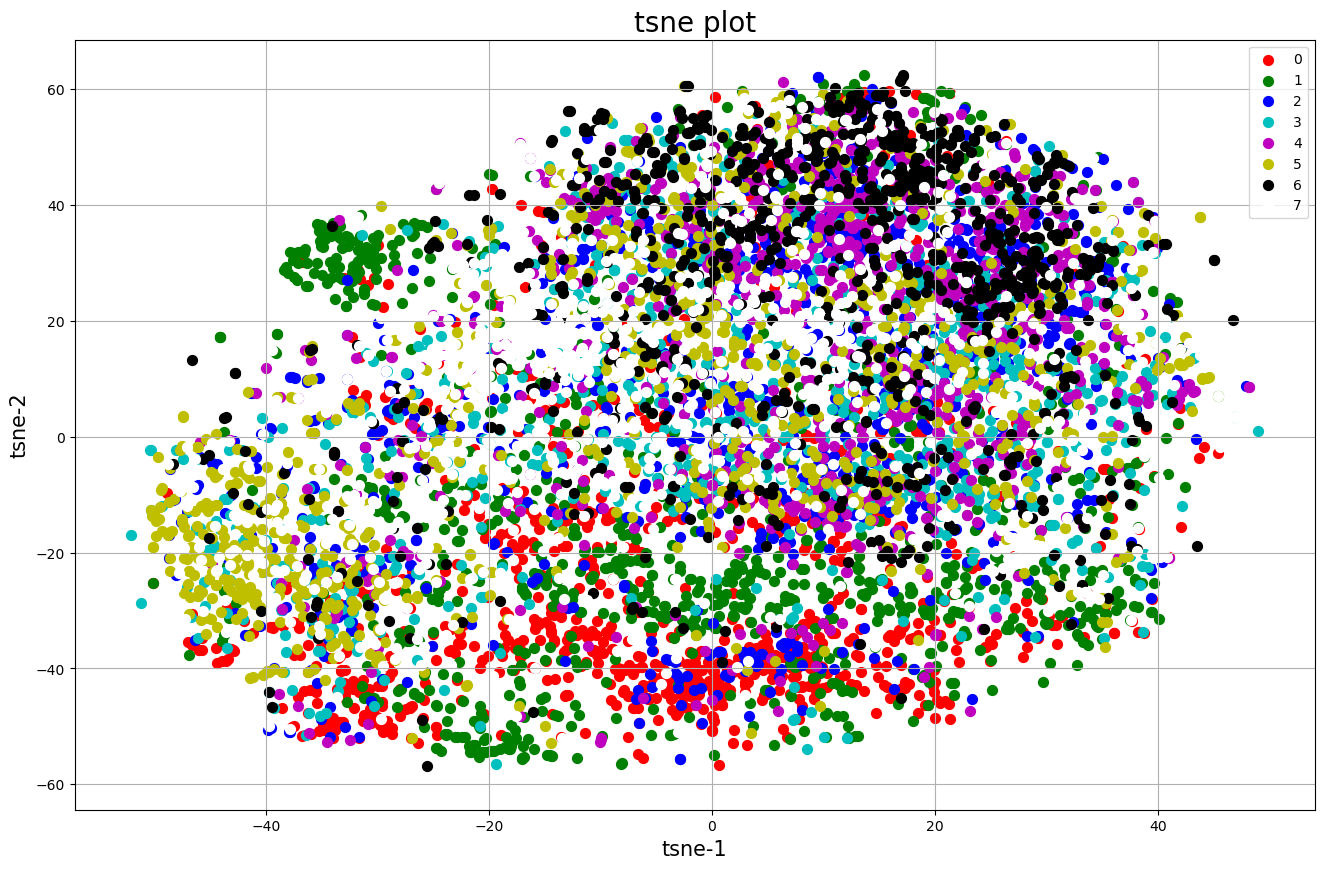

In [65]:
# call tsn_plot function for moco
#we will load the moco model
model_moco = load_moco_model()
#we will call the tsne_plot function
df_moco = tsne_plot(model_moco, test_loader)

#### Tsne of binary classifier

-----------------------------------------------------------
ConvNet
ModuleList(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Dropout(p=0.3, inplace=False)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): ReLU()
  (8): Dropout(p=0.3, inplace=False)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU()
  (13): Dropout(p=0.3, inplace=False)
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)
---------------------------------------------

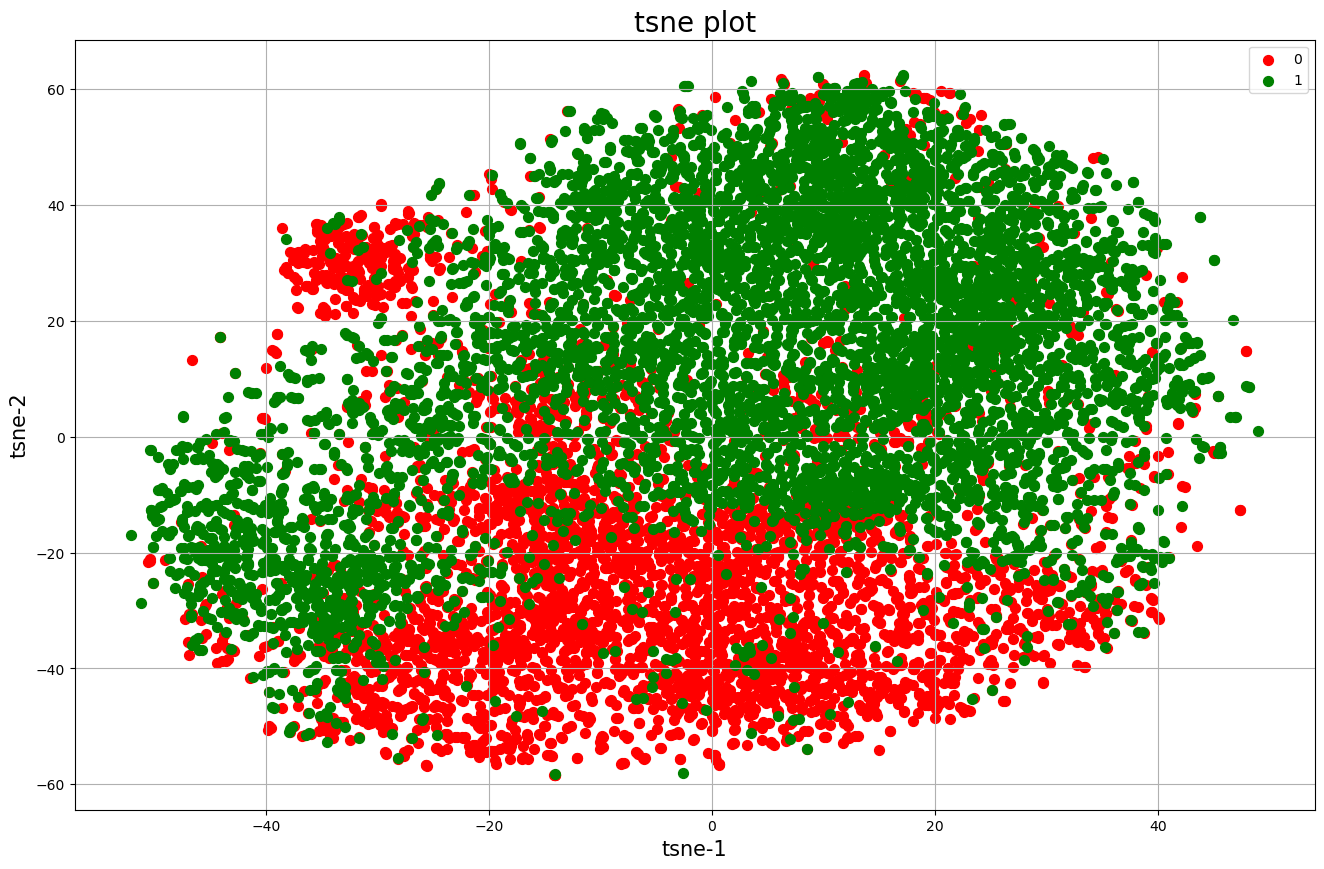

In [77]:
#load feature extractor
model = load_moco_model()
#load binary classifier
model_classifier = load_pretrained_binary_classifier()
#call tsne_plot function
df_binary = tsne_plot(model, test_loader, model_classifier)

#### Tsne of multi-class classifier

-----------------------------------------------------------
ConvNet
ModuleList(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Dropout(p=0.3, inplace=False)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): ReLU()
  (8): Dropout(p=0.3, inplace=False)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU()
  (13): Dropout(p=0.3, inplace=False)
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)
---------------------------------------------

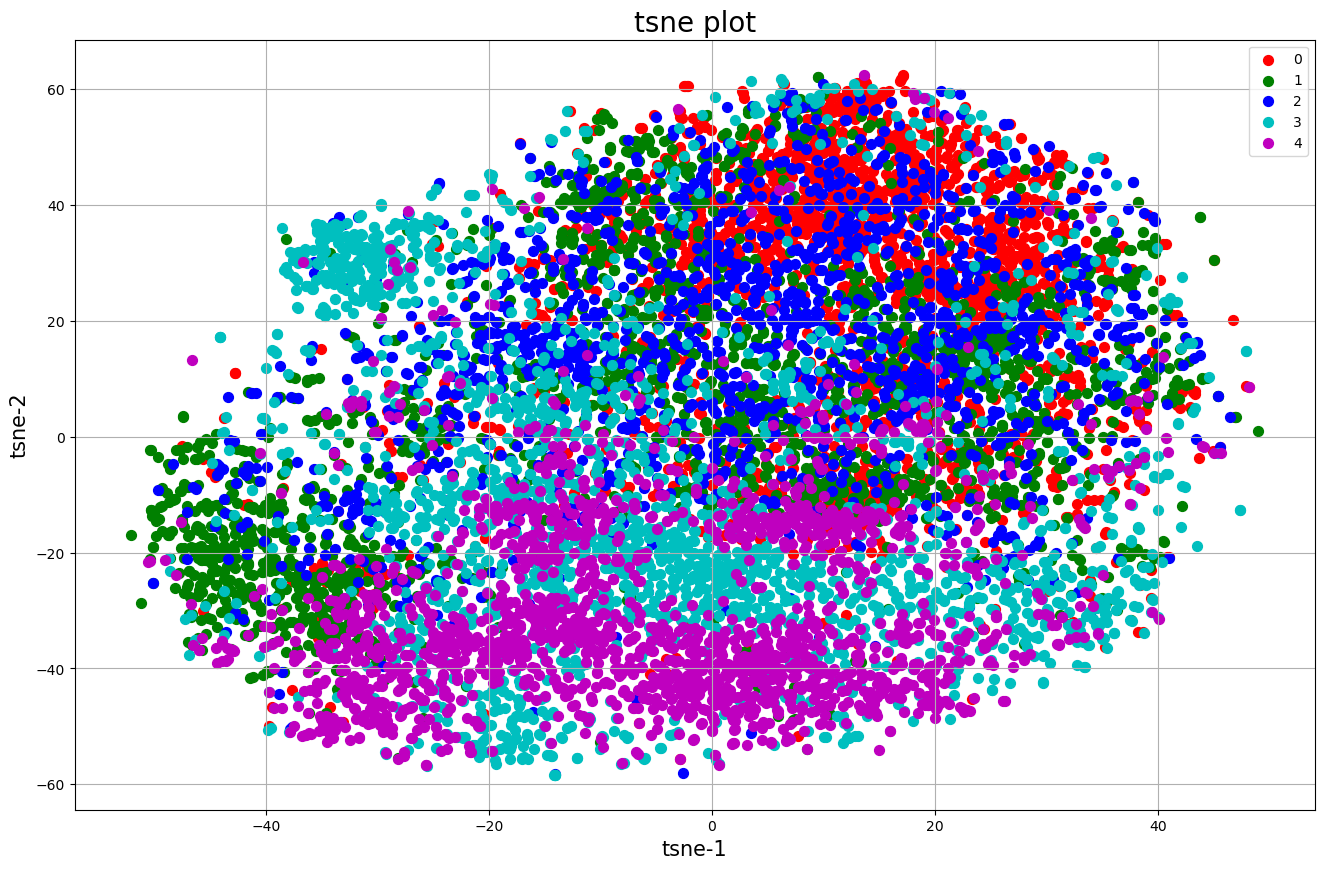

In [78]:
#load feature extractor
model = load_moco_model()
#load five class classifier
model_classifier = load_pretrained_five_class_classifier()
#call tsne_plot function
df_five = tsne_plot(model, test_loader, model_classifier)
